In [1]:
# Read the dataset hdf5 file and train a neural network

In [1]:
import numpy as np
import h5py
from random import shuffle
from random import randint
from math import ceil
import matplotlib.pyplot as plt

In [2]:
DATA_FILE = 'dataset.h5'
IMG_SIZE = 400
IMG_CHANNELS=3
PREVIEW_DATA_DIR= "Preview/"

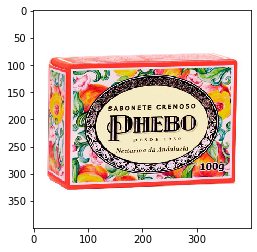

4


In [3]:
# Visualize dataset train sample

hdf5_file = h5py.File(DATA_FILE, 'r')
train_count = hdf5_file['x_train'].shape[0]
test_count = hdf5_file['x_test'].shape[0]
label_count = hdf5_file['y_train'][:].max()+1

index = randint(0, train_count)
image = hdf5_file['x_train'][index]
label = hdf5_file['y_train'][index]
plt.imshow(image)
plt.show()
print(label)

In [4]:
# Define deep learning model

import tensorflow as tf
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D

model = Sequential()
model.add(Conv2D(32, (5, 5), input_shape=(IMG_SIZE, IMG_SIZE, IMG_CHANNELS)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())  # this converts our 3D feature maps to 1D feature vectors
model.add(Dense(64))
model.add(Activation('relu'))
model.add(Dropout(0.5))

model.add(Dense(label_count))
model.add(Activation('softmax'))

model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])


In [5]:
# Define data augmentator

from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Preview augmentation
datagen = ImageDataGenerator(
        rotation_range=3,
        width_shift_range=0.05,
        height_shift_range=0.05,
        shear_range=0.01,
        zoom_range=0.1,
        horizontal_flip=False,
        fill_mode='nearest')

image = image.reshape((1,)+ image.shape)

c = 0

# Images will be saved to PREVIEW_DATA_DIR
for batch in datagen.flow(image, batch_size=1, save_to_dir=PREVIEW_DATA_DIR, save_prefix='preview_', save_format='jpg'):
    c += 1
    if c > 15:
        break  # otherwise the generator would loop indefinitely

train_datagen = ImageDataGenerator(rescale=1./255,rotation_range=3,shear_range=0.01,fill_mode='nearest',zoom_range=0.1, width_shift_range=0.05, height_shift_range=0.05, horizontal_flip=False)
test_datagen = ImageDataGenerator(rescale=1./255)

In [6]:
def HDF5ImageGenerator(hdf5_x, hdf5_y, image_datagen, batch_size, seed):
    sample_count  = hdf5_x.shape[0]
    count         = 0
    
    while True:
        batch_index = 0
        batches_list = list(range(int(ceil(float(sample_count) / batch_size))))
        shuffle(batches_list)
        
        while batch_index < len(batches_list):
            batch_number = batches_list[batch_index]
            start        = batch_number * batch_size
            end          = min(start + batch_size, sample_count)
            
            # Load data from disk
            x = hdf5_x[start: end]
            y = hdf5_y[start: end]
            
            # Augment batch
            generator = image_datagen.flow(x,y,batch_size=batch_size, seed = seed + count)
            augmented_x, augmented_y = next(generator)
            
            batch_index += 1
            count       += 1
            
            yield augmented_x, augmented_y
            

In [7]:
# Load features
x_train = hdf5_file['x_train']
x_test = hdf5_file['x_test']

# Load labels and one-hot encode
train_labels = hdf5_file['y_train']
test_labels  = hdf5_file['y_test']
y_train      = np.zeros((train_labels.shape[0], label_count))
y_test       = np.zeros((test_labels.shape[0] , label_count))

y_train[np.arange(train_labels.shape[0]), train_labels] = 1
y_test[np.arange(test_labels.shape[0]), test_labels]    = 1

In [8]:
# Define HDF5ImageGenerator 

batch_size = 16
seed       = 0

train_generator = HDF5ImageGenerator(x_train, y_train, train_datagen, batch_size, seed)
test_generator  = HDF5ImageGenerator(x_test, y_test, test_datagen, 1, seed)

(32, 400, 400, 3)
(32, 7)


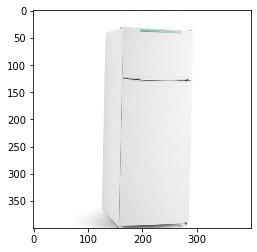

In [27]:
# Test generator

x, y = next(train_generator)
print(x.shape)
print(y.shape)
plt.imshow(x[0, :])
plt.show()

In [9]:
# Train model

epochs = 3
model.fit_generator(train_generator, validation_data=test_generator, steps_per_epoch=len(x_train) // 32, epochs=epochs, validation_steps=20)

Epoch 1/3
53/53 [==============================] - 37s 703ms/step - loss: 2.2210 - accuracy: 0.4333 - val_loss: 0.8402 - val_accuracy: 0.6500
Epoch 2/3
53/53 [==============================] - 35s 669ms/step - loss: 1.0263 - accuracy: 0.6769 - val_loss: 0.4674 - val_accuracy: 0.8500
Epoch 3/3
53/53 [==============================] - 37s 692ms/step - loss: 0.8186 - accuracy: 0.7084 - val_loss: 0.6787 - val_accuracy: 0.6500


predicted:  Dataset/whirlpool/
label:  Dataset/whirlpool/


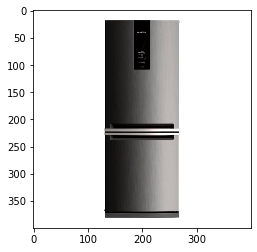

In [12]:
# Predict

brandNames = ['Dataset/LG/', 'Dataset/nestlé/', 'Dataset/whirlpool/', 'Dataset/pampers/', 'Dataset/pantene/', 'Dataset/dell/', 'Dataset/gillette/']
index = 1
imgs = x_test[index:index+1]
image = tf.cast(imgs, tf.float32)
preds = model.predict(image)
class_index = np.argmax(preds[0])
plt.imshow(imgs[0])
print('predicted: ', brandNames[class_index])
print('label: ', brandNames[np.argmax(y_test[index])])

In [15]:
a = 1.5
type(a)

float

In [ ]:
# Close hdf5

hdf5_file.close()